# Classifying Sheet Music

An example notebook walking through each step in starting with a PDF page of sheet music and making a prediction on its composer

Imports

In [19]:
import os
import pickle
import subprocess
import torch
import numpy as np
import utils.encoders as encoders

from pathlib import Path
from hmc_mir.bootleg_score import bootleg_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer

Configurations

In [13]:
PDF = Path("bach.pdf")
'''PDF file path: PosixPath'''
PAGE = 0
'''Page index (0-indexed): int'''
MODEL = Path("/home/ajain/ttmp/EWLLMs/experiments/100_way_linear_probes/dense_1_1/checkpoint-13128")
'''Model path: PosixPath'''
FRAGMENT_LENGTH = 64
'''Length of each fragment to inference on: int'''

'Length of each fragment to inference on: int'

### Extracting Bootleg Score From PDF

Convert PDF page to PNG

In [5]:
def convertPDF2PNG(pdffile, pngfile):
    pngfile.parent.mkdir(parents=True, exist_ok=True)

    print('Converting {}'.format(pdffile))
    try:
        subprocess.call(['convert', '-density', '300', '-alpha', 'remove', '-resize', '2550', pdffile, pngfile])
    except FileNotFoundError:
        pass
png_path = PDF.parent / (PDF.stem + '.png')
convertPDF2PNG(PDF, png_path)

Converting bach.pdf


convert-im6.q16: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG `bach.png' @ warning/png.c/MagickPNGWarningHandler/1667.


Get bootleg score from PNG

In [6]:
img_path = png_path.parent / (png_path.stem + '-' + str(PAGE) + png_path.suffix)
bscore_path = img_path.parent / (img_path.stem + '.pkl')
bootleg_score.processImageFile(img_path, bscore_path)

with open(bscore_path, 'rb') as f:
    bscore = pickle.load(f)['bscore']

Processing bach-0.png


Visualize bootleg score

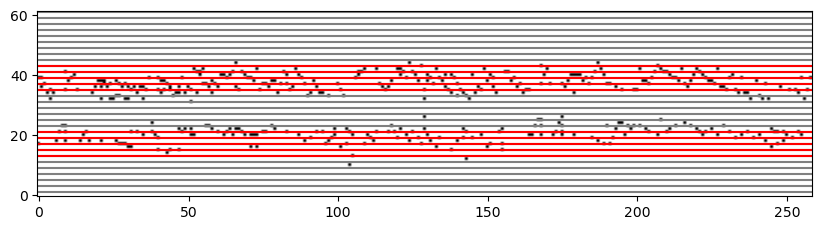

In [7]:
bootleg_score.visualizeBootlegScore(bscore, lines = [13, 15, 17, 19, 21, 35, 37, 39, 41, 43])

### Classify Page

Create 64 length fragments with 50% overlap for ensemble prediction in shape (64, # Possible Note Events)

In [8]:
fragments = []
for i in range(0, bscore.shape[1], int(FRAGMENT_LENGTH/2)):
    fragments.append(bscore[:,i:i+FRAGMENT_LENGTH].T)
    if i + FRAGMENT_LENGTH >= bscore.shape[1]:
        break

Encode fragments

In [9]:
fragments = [encoders.dense_encoder(fragment, block_size=[1,1]) for fragment in fragments]

Make fragment-level predictions with model

In [22]:
classifier = AutoModelForSequenceClassification.from_pretrained(MODEL).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(MODEL)
preds = []
classifier.eval()
with torch.no_grad():
    for fragment in fragments:
        input_ids = tokenizer.encode(fragment, return_tensors='pt').to('cuda')
        logits = classifier(input_ids)[0]
        preds.append(logits)
torch.mean(torch.cat(preds), dim=1)

tensor([-0.2461, -0.3558, -0.2287, -0.3302, -0.4072, -0.3212, -0.3867, -0.3994],
       device='cuda:0')

In [ ]:
with open('/mnt/data0/BSCRC/data/9_way_dataset.pkl', "rb") as f:
    data = pickle.load(f)
preds = np.load('/home/ajain/ttmp/EWLLMs/experiments/9_way_linear_probes/dense_1_1/test_preds.npy')
y_test = data[5]

evaluation.create_confusion_matrix(preds, y_test)